In [3]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

# Dimensionality reduction
from sklearn.decomposition import PCA

# Model selection and evaluation
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier

# Handling imbalance
from imblearn.over_sampling import SMOTE

# Tree-based models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [4]:
train_data = pd.read_csv("./train.csv")
df = train_data.copy()

In [5]:
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [10]:
def config():
    return {
        "categorical_columns": ["Stage_fear", "Drained_after_socializing"],
        "numerical_columns": [
            "Time_spent_Alone",
            "Social_event_attendance",
            "Going_outside",
            "Friends_circle_size",
            "Post_frequency"
        ],
        "target": "Personality"
    }

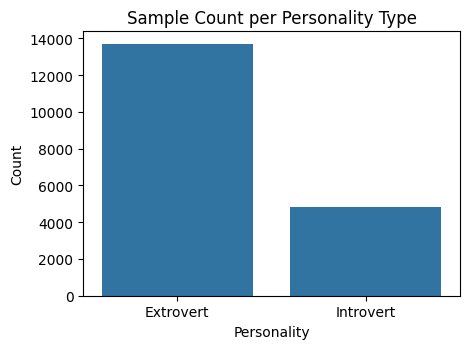

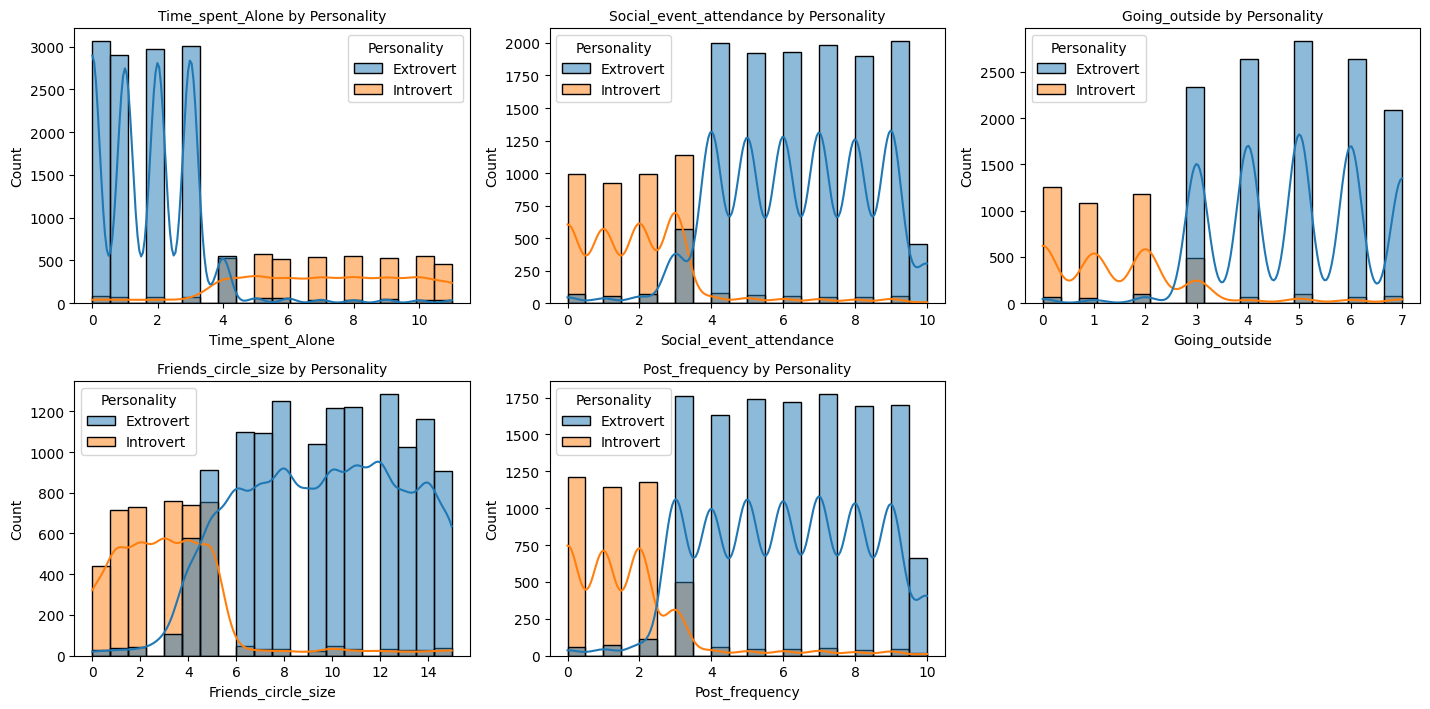

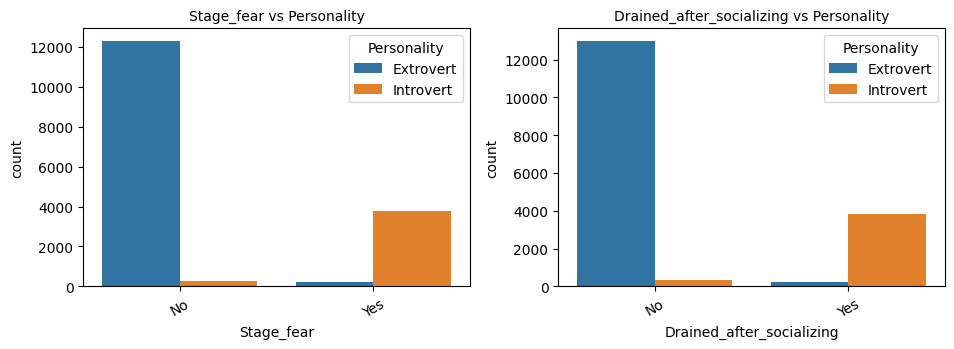

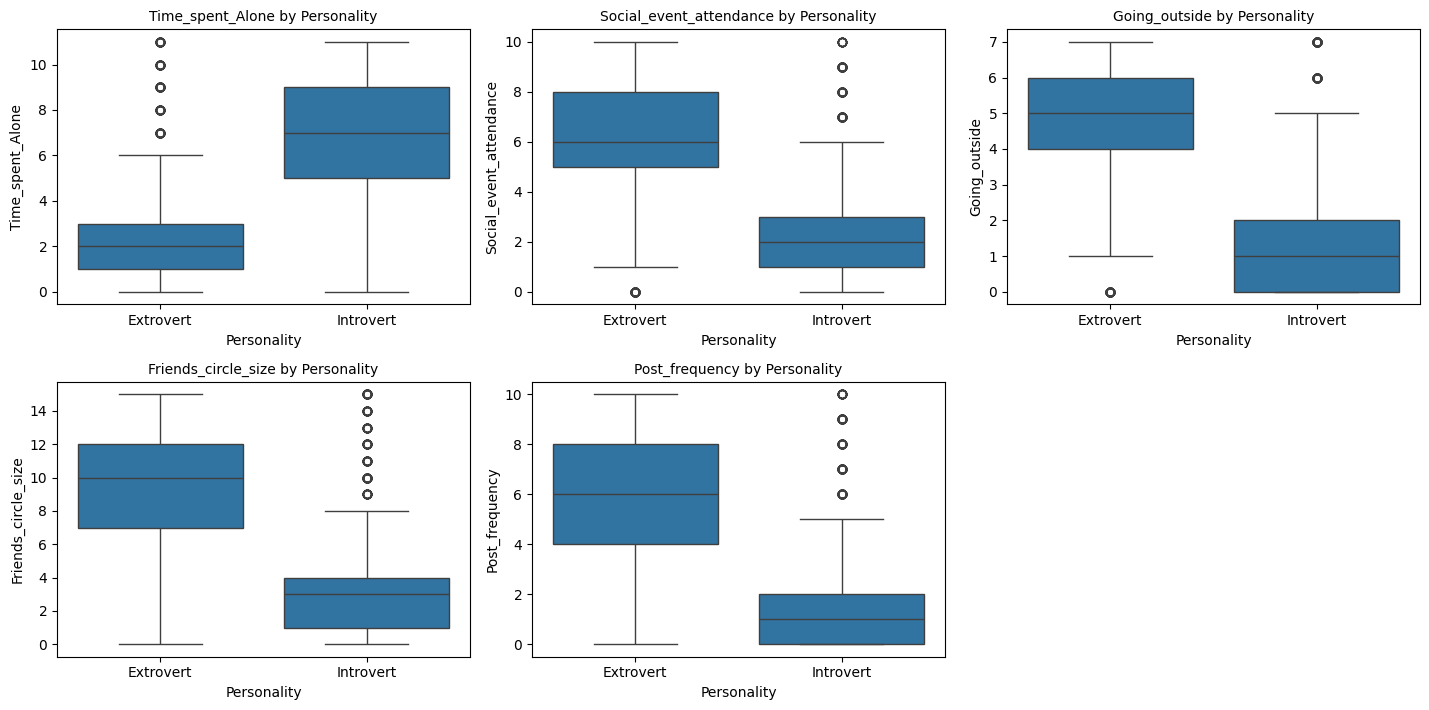

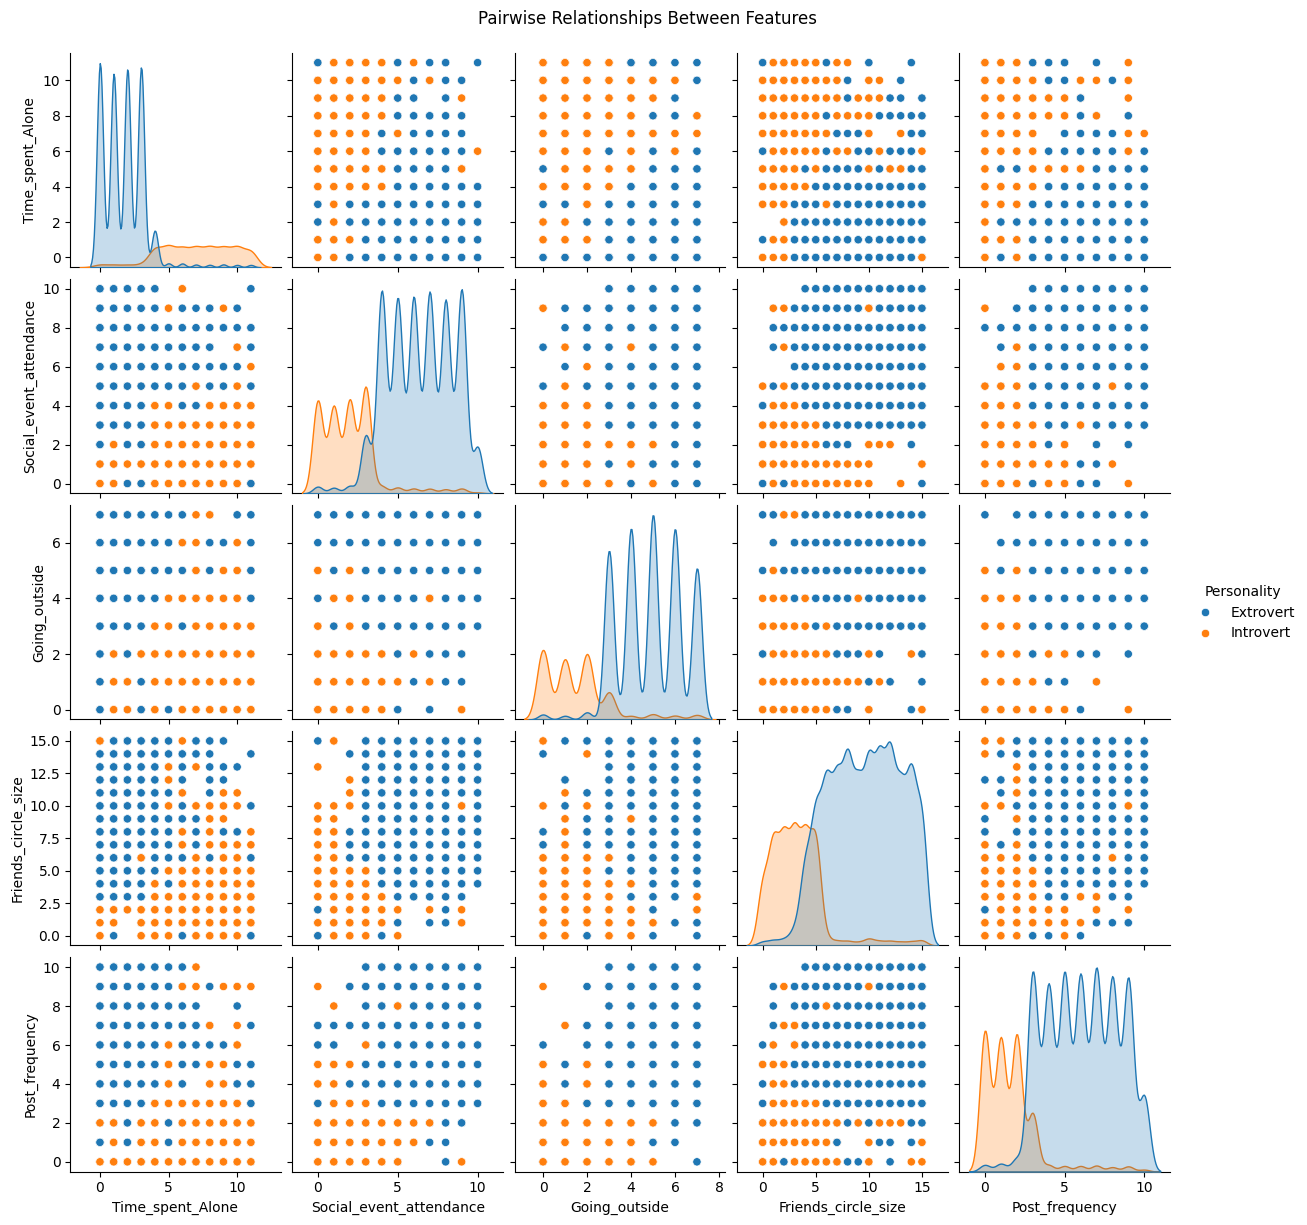

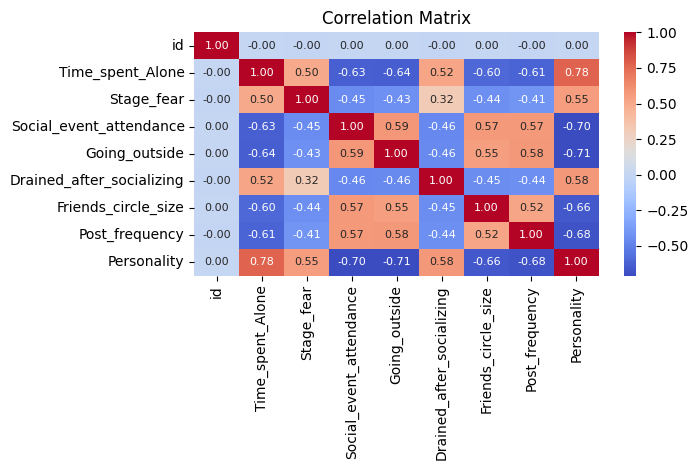

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def config():
    return {
        "categorical_columns": ["Stage_fear", "Drained_after_socializing"],
        "numerical_columns": [
            "Time_spent_Alone",
            "Social_event_attendance",
            "Going_outside",
            "Friends_circle_size",
            "Post_frequency"
        ],
        "target": "Personality"
    }

def bin(df, scale=1):
    plt.figure(figsize=(4 * scale, 3 * scale))
    sns.countplot(data=df, x=config()["target"])
    plt.title('Sample Count per Personality Type', fontsize=12)
    plt.xlabel('Personality')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def distribution_based_characteristics(df, scale=1):
    num_cols = config()["numerical_columns"]
    ncols = 3
    nrows = (len(num_cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols * scale, 3 * nrows * scale))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.histplot(data=df, x=col, hue='Personality', kde=True, bins=20, ax=axes[i])
        axes[i].set_title(f'{col} by Personality', fontsize=10)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Categorical count plots
    cat_cols = config()["categorical_columns"]
    ncols = 3
    nrows = (len(cat_cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols * scale, 3 * nrows * scale))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        sns.countplot(data=df, x=col, hue='Personality', ax=axes[i])
        axes[i].set_title(f'{col} vs Personality', fontsize=10)
        axes[i].tick_params(axis='x', rotation=30)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def boxPlt(df, scale=1):
    num_cols = config()["numerical_columns"]
    ncols = 3
    nrows = (len(num_cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols * scale, 3 * nrows * scale))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.boxplot(data=df, x='Personality', y=col, ax=axes[i])
        axes[i].set_title(f'{col} by Personality', fontsize=10)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def pairwise_relationship(df, scale=1):
    sns.pairplot(df, hue='Personality', vars=config()["numerical_columns"], height=2 * scale)
    plt.suptitle('Pairwise Relationships Between Features', y=1.02, fontsize=12)
    plt.show()

def correlation_matrix(df, scale=1):
    # Encode categorical variables for correlation
    for col in config()["categorical_columns"]:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category').cat.codes

    if df[config()["target"]].dtype == 'object':
            df[config()["target"]] = df[config()["target"]].astype('category').cat.codes

    corr_matrix = df.corr()

    plt.figure(figsize=(6 * scale, 4 * scale))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title("Correlation Matrix", fontsize=12)
    plt.tight_layout()
    plt.show()

def data_analysis(df, scale=1):
    bin(df, scale)
    distribution_based_characteristics(df, scale)
    boxPlt(df, scale)
    pairwise_relationship(df, scale)
    correlation_matrix(df, scale)

# Example usage:
data_analysis(df, scale=1.2)

Key observations from exploratory data analysis


*   imbalance data - more samples for extroverts compared to introverts
*   positive or negative coorelation (greater than 50%) across different features
*   outliers available in sample. e.g "going outside" count is close to 0 for extroverts and high for introverts. simlilarly timespent alone








In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import pandas as pd

# Globals for reversibility
encoders = {}
target_encoder = None
scaler = None
pca_model = None
poly = None
num_imputer = None
cat_imputer = None

# ------------------ FIT STAGE (TRAIN ONLY) ------------------ #

def fit_impute(df):
    global num_imputer, cat_imputer
    df = df.copy()

    # Numerical imputation
    num_cols = config()["numerical_columns"]
    num_imputer = SimpleImputer(strategy="median")
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

    # Categorical imputation
    cat_cols = config()["categorical_columns"]
    cat_imputer = SimpleImputer(strategy="constant", fill_value="Unknown")
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    return df

def fit_encode_categoricals(df):
    global encoders, target_encoder
    df = df.copy()
    for col in config()["categorical_columns"]:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le
    target_encoder = LabelEncoder()
    df[config()["target"]] = target_encoder.fit_transform(df[config()["target"]])
    return df

def fit_handle_outliers(df, z_thresh=3):
    df = df.copy()
    for col in config()["numerical_columns"]:
        z_scores = (df[col] - df[col].mean()) / df[col].std()
        df.loc[z_scores.abs() > z_thresh, col] = df[col].mean()
    return df

def fit_normalize_data(df):
    global scaler
    df = df.copy()
    cols = config()["numerical_columns"] + config()["categorical_columns"]
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df

def fit_add_interaction_features(df):
    global poly
    df = df.copy()
    cols = config()["numerical_columns"] + config()["categorical_columns"]
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    inter = poly.fit_transform(df[cols])
    return pd.DataFrame(inter, columns=poly.get_feature_names_out(cols), index=df.index)

def fit_apply_pca(df, n_components=2):
    global pca_model
    pca_model = PCA(n_components=n_components)
    components = pca_model.fit_transform(df)
    return pd.DataFrame(components, columns=[f"PC{i+1}" for i in range(n_components)], index=df.index)

def fit_train_pipeline(df):
    df = fit_impute(df)
    df = fit_encode_categoricals(df)
    df = fit_handle_outliers(df)
    df = fit_normalize_data(df)
    df_inter = fit_add_interaction_features(df)
    df_pca = fit_apply_pca(df_inter)
    base_cols = config()["numerical_columns"] + config()["categorical_columns"]
    df_final = pd.concat([df[base_cols], df_pca], axis=1)
    y = df[config()["target"]]
    return df_final, y

# ------------------ TRANSFORM STAGE (TEST/NEW DATA) ------------------ #

def transform_impute(df):
    df = df.copy()
    df[config()["numerical_columns"]] = num_imputer.transform(df[config()["numerical_columns"]])
    df[config()["categorical_columns"]] = cat_imputer.transform(df[config()["categorical_columns"]])
    return df

def transform_encode_categoricals(df):
    df = df.copy()
    for col in config()["categorical_columns"]:
        df[col] = encoders[col].transform(df[col])
    df[config()["target"]] = target_encoder.transform(df[config()["target"]])
    return df

def transform_handle_outliers(df, z_thresh=3):
    df = df.copy()
    for col in config()["numerical_columns"]:
        z_scores = (df[col] - df[col].mean()) / df[col].std()
        df.loc[z_scores.abs() > z_thresh, col] = df[col].mean()
    return df

def transform_normalize_data(df):
    df = df.copy()
    cols = config()["numerical_columns"] + config()["categorical_columns"]
    df[cols] = scaler.transform(df[cols])
    return df

def transform_add_interaction_features(df):
    df = df.copy()
    cols = config()["numerical_columns"] + config()["categorical_columns"]
    inter = poly.transform(df[cols])
    return pd.DataFrame(inter, columns=poly.get_feature_names_out(cols), index=df.index)

def transform_apply_pca(df):
    components = pca_model.transform(df)
    return pd.DataFrame(components, columns=[f"PC{i+1}" for i in range(components.shape[1])], index=df.index)

def transform_test_pipeline(df):
    df = transform_impute(df)
    df = transform_encode_categoricals(df)
    df = transform_handle_outliers(df)
    df = transform_normalize_data(df)
    df_inter = transform_add_interaction_features(df)
    df_pca = transform_apply_pca(df_inter)
    base_cols = config()["numerical_columns"] + config()["categorical_columns"]
    df_final = pd.concat([df[base_cols], df_pca], axis=1)
    y = df[config()["target"]]
    return df_final, y

# ------------------ Optional Utilities ------------------ #

def decode_target(y_encoded):
    return target_encoder.inverse_transform(y_encoded)

def decode_column(col_name, values):
    return encoders[col_name].inverse_transform(values)

def inverse_normalize(df):
    df = df.copy()
    cols = config()["numerical_columns"] + config()["categorical_columns"]
    df[cols] = scaler.inverse_transform(df[cols])
    return df

In [11]:
df = train_data.copy()
X_train, y_train = fit_train_pipeline(df)

Tuning XGB...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBClassifier: {'subsample': 1, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1} with AUC: 0.9681
Tuning LGB...
[LightGBM] [Info] Number of positive: 4825, number of negative: 13699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 18524, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260473 -> initscore=-1.043512
[LightGBM] [Info] Start training from score -1.043512
Best params for LGBMClassifier: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 150, 'learning_rate': 0.01} with AUC: 0.9673
Tuning CatBoost...
Best params for CatBoostClassifier: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 50, 'depth': 5} with AUC: 0.9694


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 7306, number of negative: 7306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7306, number of negative: 7306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1659
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 7306, number of negative: 7306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7306, number of negative: 7306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1577
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 7306, number of negative: 7306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7306, number of negative: 7306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 7306, number of negative: 7306
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7306, number of negative: 7306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 14612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 7306, number of negative: 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 7307, number of negative: 7306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 14613, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500034 -> initscore=0.000137
[LightGBM] [Info] Start training from score 0.000137
[LightGBM] [Info] Number of positive: 7306, number of negative: 7307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 14613, number of used features: 9
[LightGBM] [Info] [binary:

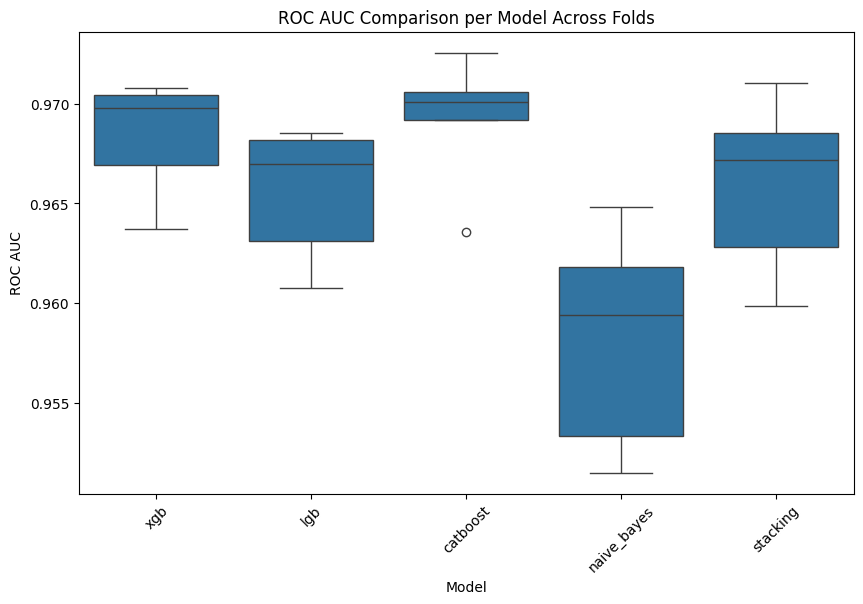

(    fold        model   roc_auc
 0      1          xgb  0.970433
 1      1          lgb  0.968516
 2      1     catboost  0.970599
 3      1  naive_bayes  0.961824
 4      1     stacking  0.968547
 5      2          xgb  0.970774
 6      2          lgb  0.966958
 7      2     catboost  0.970113
 8      2  naive_bayes  0.951497
 9      2     stacking  0.971019
 10     3          xgb  0.963701
 11     3          lgb  0.960754
 12     3     catboost  0.963577
 13     3  naive_bayes  0.953356
 14     3     stacking  0.959864
 15     4          xgb  0.966921
 16     4          lgb  0.963101
 17     4     catboost  0.969178
 18     4  naive_bayes  0.959382
 19     4     stacking  0.962807
 20     5          xgb  0.969766
 21     5          lgb  0.968171
 22     5     catboost  0.972566
 23     5  naive_bayes  0.964810
 24     5     stacking  0.967164,
 StackingClassifier(estimators=[('xgb',
                                 CalibratedClassifierCV(cv=3,
                                       

In [12]:
def stacked_model_training(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    n_splits: int = 5,
    random_state: int = 42,
    n_iter_tune: int = 10,
    plot_results: bool = True
):
    """
    Train a stacking ensemble with hyperparameter tuning, SMOTE, and probability calibration.

    Args:
        X_train (pd.DataFrame): Training features (already encoded if needed).
        y_train (pd.Series): Training target.
        n_splits (int): Number of stratified folds.
        random_state (int): Random seed.
        n_iter_tune (int): RandomizedSearchCV iterations for tuning.
        plot_results (bool): Whether to plot ROC AUC comparison.

    Returns:
        results_df (pd.DataFrame): ROC AUC scores per fold and model.
        stacking_clf (StackingClassifier): Final stacking model trained on last fold.
    """

    # Scale features
    #scaler = StandardScaler()
    #X_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

    # Base models and hyperparam grids
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    lgb = LGBMClassifier(random_state=random_state)
    cat = CatBoostClassifier(verbose=0, random_state=random_state)
    nb = GaussianNB()

    param_grids = {
        'xgb': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1]
        },
        'lgb': {
            'n_estimators': [50, 100, 150],
            'num_leaves': [31, 50, 70],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1]
        },
        'cat': {
            'iterations': [50, 100, 150],
            'depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'l2_leaf_reg': [1, 3, 5]
        }
    }

    def tune_model(model, param_grid, X_tune, y_tune):
        rs = RandomizedSearchCV(
            model, param_grid, n_iter=n_iter_tune, cv=3,
            scoring='roc_auc', n_jobs=-1, random_state=random_state, verbose=0
        )
        rs.fit(X_tune, y_tune)
        print(f"Best params for {model.__class__.__name__}: {rs.best_params_} with AUC: {rs.best_score_:.4f}")
        return rs.best_estimator_

    print("Tuning XGB...")
    xgb_best = tune_model(xgb, param_grids['xgb'], X_train, y_train)

    print("Tuning LGB...")
    lgb_best = tune_model(lgb, param_grids['lgb'], X_train, y_train)

    print("Tuning CatBoost...")
    cat_best = tune_model(cat, param_grids['cat'], X_train, y_train)

    nb_best = nb  # No tuning for NB

    # Calibrated models
    calibrated_learners = [
        ('xgb', CalibratedClassifierCV(xgb_best, method='isotonic', cv=3)),
        ('lgb', CalibratedClassifierCV(lgb_best, method='isotonic', cv=3)),
        ('catboost', CalibratedClassifierCV(cat_best, method='isotonic', cv=3)),
        ('naive_bayes', CalibratedClassifierCV(nb_best, method='isotonic', cv=3))
    ]

    meta_learner = LogisticRegression(max_iter=1000, random_state=random_state)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    results = {'fold': [], 'model': [], 'roc_auc': []}

    stacking_clf = None

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        smote = SMOTE(random_state=random_state)
        X_tr_sm, y_tr_sm = smote.fit_resample(X_tr, y_tr)

        for name, model in calibrated_learners:
            model.fit(X_tr_sm, y_tr_sm)
            y_proba = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_proba)
            results['fold'].append(fold)
            results['model'].append(name)
            results['roc_auc'].append(auc)

        stacking_clf = StackingClassifier(
            estimators=calibrated_learners,
            final_estimator=meta_learner,
            cv=None,
            stack_method='predict_proba',
            passthrough=True,
            n_jobs=-1
        )
        stacking_clf.fit(X_tr_sm, y_tr_sm)
        y_stack_proba = stacking_clf.predict_proba(X_val)[:, 1]
        stack_auc = roc_auc_score(y_val, y_stack_proba)

        results['fold'].append(fold)
        results['model'].append('stacking')
        results['roc_auc'].append(stack_auc)

        print(f"Fold {fold} done. Stacking ROC AUC: {stack_auc:.4f}")

    results_df = pd.DataFrame(results)

    print("\nAverage ROC AUC scores per model:")
    print(results_df.groupby('model')['roc_auc'].mean())

    if plot_results:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=results_df, x='model', y='roc_auc')
        plt.title('ROC AUC Comparison per Model Across Folds')
        plt.ylabel('ROC AUC')
        plt.xlabel('Model')
        plt.xticks(rotation=45)
        plt.show()

    return results_df, stacking_clf

stacked_model_training(X_train, y_train)

In [2]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00
